In [42]:
import pathlib

import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

sns.set()
pd.options.display.float_format = "{:.2f}".format

We begin by reading the data and summarizing the variables.

In [43]:
path = pathlib.Path.home() / 'data' / 'sleuth3' / 'case0502.csv'
df = pd.read_csv(path)
df.head()

,Percent,Judge
0,6.40,Spock's
1,8.70,Spock's
2,13.30,Spock's
3,13.60,Spock's
4,15.00,Spock's


In [44]:
df.describe()

,Percent
count,46.00
mean,26.58
std,9.18
min,6.40
25%,19.95
50%,27.50
75%,32.38
max,48.90


In [45]:
df.groupby('Judge').describe()

Percent                                          
          count  mean   std   min   25%   50%   75%   max
Judge                                                    
A          5.00 34.12 11.94 16.80 30.80 33.60 40.50 48.90
B          6.00 33.62  6.58 27.00 29.67 32.35 34.80 45.60
C          9.00 29.10  4.59 21.00 27.50 30.50 32.50 33.80
D          2.00 27.00  3.82 24.30 25.65 27.00 28.35 29.70
E          6.00 26.97  9.01 17.70 20.15 24.70 33.07 40.20
F          9.00 26.80  5.97 16.50 23.50 26.70 29.80 36.20
Spock's    9.00 14.62  5.04  6.40 13.30 15.00 17.70 23.10

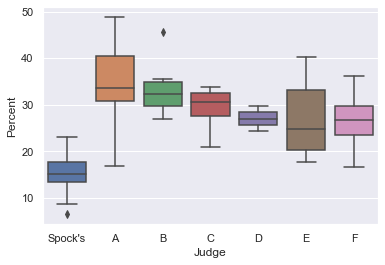

In [46]:
sns.boxplot(x='Judge', y='Percent', data=df)

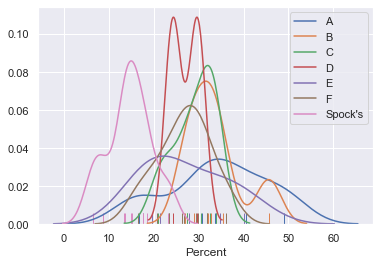

In [54]:
for judge, grp in df.groupby('Judge'):
    sns.distplot(grp['Percent'], hist=False, rug=True, label=judge)

$\it{H_0}:  \mu_{Spock} = \mu_A = \mu_B = \mu_C = \mu_D = \mu_E = \mu_F$

$\it{H_a}:$  at least one $\mu$ is different

First, we perform the test manually.

In [47]:
a = np.empty((3, 5))
a[:] = NaN
index = ['Between Groups', 'Within Groups', 'Total']
columns = ['Sum of Squares', 'd.f.', 'Mean Square', 'F Statistic', 'p-value']
dfss = pd.DataFrame(a, columns=columns, index=index)

dfss.at['Total', 'Sum of Squares'] = ((df.Percent - mu) ** 2).sum()

ssg = [((g.Percent - g.Percent.mean()) ** 2).sum() for idx, g in df.groupby('Judge')]
dfss.at['Within Groups', 'Sum of Squares'] = sum(ssg)

ssb = [
    ((g['Percent'].mean() - mu) ** 2) * len(g) 
    for _, g in df.groupby('Judge')
] 
dfss.at['Between Groups', 'Sum of Squares'] = sum(ssb)

n = len(df)
I = len(df.Judge.unique())
dfss['d.f.'] = [I - 1, n - I, n - 1]

dfss['Mean Square'] = dfss['Sum of Squares'] / dfss['d.f.']

dfss.at['Between Groups', 'F Statistic'] = dfss.at['Between Groups', 'Mean Square'] / dfss.at['Within Groups', 'Mean Square']

dfss.at['Between Groups', 'p-value'] = scipy.stats.f.sf(dfss.at['Between Groups', 'F Statistic'],
                                                        dfss.at['Between Groups', 'd.f.'],
                                                        dfss.at['Within Groups', 'd.f.'])

dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,1927.08,6,321.18,6.72,0.00
Within Groups,1864.45,39,47.81,nan,nan
Total,3791.53,45,84.26,nan,nan


In [48]:
judges = df.Judge.unique()
pargs = [df.loc[df.Judge == judge, 'Percent'] for judge in judges]
scipy.stats.f_oneway(*pargs)

F_onewayResult(statistic=6.718366123861361, pvalue=6.095822767937556e-05)

The p-value of 6.1e-5 is sufficient to reject the null hypothesis and conclude that the mean percentage of at least one judge is not the same as the mean of the other judges.

We can also do this with statsmodels.

In [49]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('Percent ~ Judge', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

          sum_sq    df    F  PR(>F)
Judge    1927.08  6.00 6.72    0.00
Residual 1864.45 39.00  nan     nan




$\it{H_0}:  \mu_{Spock} = \mu_0, where \mu_0 = \mu_A = \mu_B = \mu_C = \mu_D = \mu_E = \mu_F$

$\it{H_a}:  \mu_{Spock} \neq \mu_0$


In [61]:
a = np.empty((3, 5))
a[:] = NaN
index = ['Between Groups', 'Within Groups', 'Total']
columns = ['Sum of Squares', 'd.f.', 'Mean Square', 'F Statistic', 'p-value']
dfss = pd.DataFrame(a, columns=columns, index=index)

n = len(df)
I = len(df.Judge.unique())
dfss['d.f.'] = [I - 2, n - I, n - 2]
dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,nan,5,nan,nan,nan
Within Groups,nan,39,nan,nan,nan
Total,nan,44,nan,nan,nan


In order to facilitate further computations, we need to be able to apply a grouping for "Spock" or "not Spock".

In [63]:
df2 = df.set_index('Judge')
fcn = lambda x: x if x == "Spock's" else "Other"

ss = [((g.Percent - g.Percent.mean()) ** 2).sum() for idx, g in df2.groupby(fcn)]
dfss.at['Total', 'Sum of Squares'] = sum(ss)
dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,nan,5,nan,nan,nan
Within Groups,nan,39,nan,nan,nan
Total,2190.90,44,nan,nan,nan


In [64]:
ss = [((g.Percent - g.Percent.mean()) ** 2).sum() for idx, g in df.groupby('Judge')]
dfss.at['Within Groups', 'Sum of Squares'] = sum(ss)
dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,nan,5,nan,nan,nan
Within Groups,1864.45,39,nan,nan,nan
Total,2190.90,44,nan,nan,nan


In [65]:
dfss.at['Between Groups', 'Sum of Squares'] = dfss.at['Total', 'Sum of Squares'] - dfss.at['Within Groups', 'Sum of Squares'] 
dfss



,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,326.46,5,nan,nan,nan
Within Groups,1864.45,39,nan,nan,nan
Total,2190.90,44,nan,nan,nan


In [66]:
dfss['Mean Square'] = dfss['Sum of Squares'] / dfss['d.f.']

dfss.at['Between Groups', 'F Statistic'] = dfss.at['Between Groups', 'Mean Square'] / dfss.at['Within Groups', 'Mean Square']

dfss.at['Between Groups', 'p-value'] = scipy.stats.f.sf(dfss.at['Between Groups', 'F Statistic'],
                                                        dfss.at['Between Groups', 'd.f.'],
                                                        dfss.at['Within Groups', 'd.f.'])

dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,326.46,5,65.29,1.37,0.26
Within Groups,1864.45,39,47.81,nan,nan
Total,2190.90,44,49.79,nan,nan
